### Классификация cola

In [1]:
!pip install datasets --quiet
!pip install transformers --quiet

     |████████████████████████████████| 325 kB 4.2 MB/s 
     |████████████████████████████████| 134 kB 38.3 MB/s 
     |████████████████████████████████| 67 kB 3.8 MB/s 
     |████████████████████████████████| 1.1 MB 44.6 MB/s 
     |████████████████████████████████| 212 kB 49.2 MB/s 
     |████████████████████████████████| 127 kB 49.7 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 271 kB 39.0 MB/s 
     |████████████████████████████████| 144 kB 40.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.8 MB 4.1 MB/s 
     |████████████████████████████████| 6.5 MB 34.0 MB/s 
     |████████████████████████████████| 895 kB 42.3 MB/s 
     |████████████████████████████████| 596

In [42]:
from datasets import load_dataset
dataset = load_dataset('glue', 'cola')

Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [43]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})

Посмотрим на предложения в датасете

In [44]:
dataset['train']['sentence'][:10]

["Our friends won't buy this analysis, let alone the next one we propose.",
 "One more pseudo generalization and I'm giving up.",
 "One more pseudo generalization or I'm giving up.",
 'The more we study verbs, the crazier they get.',
 'Day by day the facts are getting murkier.',
 "I'll fix you a drink.",
 'Fred watered the plants flat.',
 'Bill coughed his way out of the restaurant.',
 "We're dancing the night away.",
 'Herman hammered the metal flat.']

Также попробуем представить эмбеддинги предложений как сумму эмбеддингов слов, из которых они состоят. Так мы будем проверять приемлемость предложения по наличию в нем определенных сочетаний слов. Такой способ не будет учитывать порядка слов, подчинение слов, но надо с чего-то начинать

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stopWords = set(stopwords.words('english'))

wnl = nltk.WordNetLemmatizer()

def preproc_nltk(text):
    return " ".join([wnl.lemmatize(word) for word in word_tokenize(text.lower()) if word not in stopWords])

In [ ]:
!pip install fasttext --quiet

     |████████████████████████████████| 68 kB 3.8 MB/s 


In [ ]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')
embeddings_pretrained = fasttext.load_model('cc.en.300.bin')

In [ ]:
for t in ['train', 'validation', 'test']:
    t_dataset = dataset[t]

    embeddings = []

    for data in t_dataset:
        sent = data['sentence']

        sent = preproc_nltk(sent)

        emb = embeddings_pretrained.get_sentence_vector(sent)

        embeddings.append(emb)

    dataset[t] = dataset[t].add_column('embedding', embeddings)

In [3]:
import torch
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [68]:
def get_fc(in_dim, out_dim, p):
    torch.manual_seed(1)

    model = nn.Sequential(
        nn.Linear(in_dim, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(p),

        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(p),

        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(p),

        nn.Linear(256, out_dim)
    )
    
    return model 

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'embedding'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'embedding'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'embedding'],
        num_rows: 1063
    })
})

In [27]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset['train'], batch_size=128, shuffle=False)
val_loader = DataLoader(dataset['validation'], batch_size=128, shuffle=False)

In [33]:
from meltools import train_fc, evaluate_fc, get_model_and_tokenizer, train_model, evaluate_model

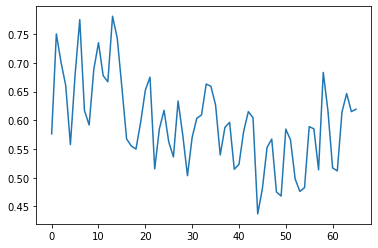

100%|██████████| 67/67 [00:05<00:00, 13.18it/s]


In [28]:
model = get_fc(300, 2, 0.2).to('cpu')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.2, step_size=60)

train_fc(model, optimizer, criterion, scheduler, train_loader,
            num_epochs=3, device='cpu')

In [31]:
evaluate_fc(model, val_loader, 'cpu')

Accuracy: 0.6912751793861389
F1 score: 0.8174603174603174


Попробуем трансформеры

In [37]:
model, tokenizer = get_model_and_tokenizer('bert-base-uncased')

model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [35]:
evaluate_model(model, tokenizer, val_loader, 'cpu')

Accuracy: 0.30968359112739563
F1 score: 0.01639344262295082


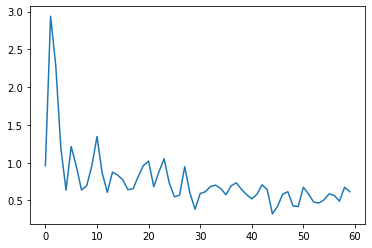

100%|██████████| 67/67 [09:33<00:00,  8.57s/it]


In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.2, step_size=30)

train_model(model, tokenizer, optimizer, criterion, scheduler, train_loader,
            num_epochs=1, device='cpu')

In [39]:
evaluate_model(model, tokenizer, val_loader, 'cpu')

Accuracy: 0.6912751793861389
F1 score: 0.8174603174603174


RoBERTa

In [40]:
model, tokenizer = get_model_and_tokenizer('roberta-base')

model = model.to(device)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [41]:
evaluate_model(model, tokenizer, val_loader, 'cpu')

Accuracy: 0.6912751793861389
F1 score: 0.8174603174603174


Похоже, что Roberta уже предобучена на cola, и, возможно, BERT тоже (Так как accuracy 0.309 - accuracy 0.691, но с перепутаными местами классами. И в итоге все модели достигают одинакового качества. Попробуем использовать что-то другое

In [52]:
import numpy as np

def get_X_y(dataset):
    embeddings = []
    labels = []

    for data in dataset:
        emb, label = data['embedding'], data['label']

        embeddings.append(emb)
        labels.append(label)
    return np.array(embeddings), np.array(labels)

X_train, y_train = get_X_y(dataset['train'])
X_val, y_val = get_X_y(dataset['validation'])

#### Логистическая регрессия

In [53]:
from sklearn.metrics import f1_score

def evaluate_metrics(preds, correct):
    print('Accuracy:', (correct == preds).mean())
    print('F1 score:', f1_score(correct, preds))

In [54]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
preds = clf.predict(X_val)
evaluate_metrics(preds, y_val)

Accuracy: 0.6912751677852349
F1 score: 0.8174603174603174


In [58]:
preds.mean()

1.0

Оказывается у нас получился константный классификатор, будем исправлять

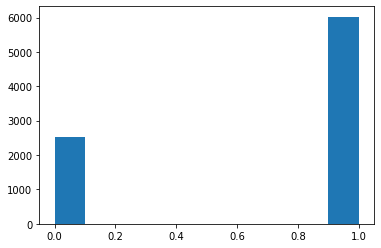

In [65]:
import matplotlib.pyplot as plt

plt.hist(y_train)
plt.show()

In [66]:
ones = y_train.mean()
zeros = 1 - ones
ones, zeros

(0.704362062916618, 0.29563793708338204)

Вернемся к обучению нейросетей, добавив параметр weight в лосс, чтобы ошибки на менее представленном классе больше штрафовались

Также для измерения качества нужно использовать какую-то другую метрику, которая учитывает и 0 класс. Такой является Phi coefficient или коэффициент корреляции Метьюса (1 соответствует идеальному предсказанию, 0 - случайному, -1 - противоположному)

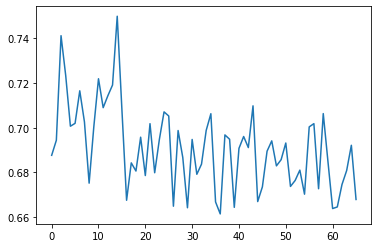

100%|██████████| 67/67 [00:04<00:00, 13.41it/s]


In [105]:
model = get_fc(300, 2, 0.2).to('cpu')

criterion = nn.CrossEntropyLoss(weight = torch.tensor([1 / zeros, 1 / ones], dtype=torch.float))
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.2, step_size=40)

train_fc(model, optimizer, criterion, scheduler, train_loader,
            num_epochs=3, device='cpu')

In [106]:
from sklearn.metrics import matthews_corrcoef

preds = []

model.eval()
with torch.no_grad():
    for data in val_loader:
        text = torch.stack(data['embedding']).to(torch.float).to(device).t()

        outputs = model(text)

        preds += outputs.argmax(axis=1)

matthews_corrcoef(y_val, preds)

0.020649606848751945

### BERT

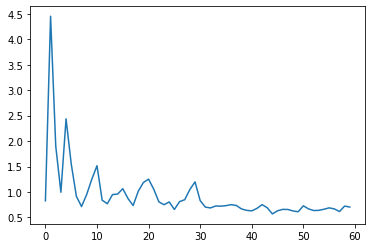

100%|██████████| 67/67 [09:36<00:00,  8.60s/it]


In [100]:
model, tokenizer = get_model_and_tokenizer('bert-base-uncased')

model = model.to(device)

criterion = nn.CrossEntropyLoss(weight = torch.tensor([1 / zeros, 1 / ones], dtype=torch.float))
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.2, step_size=20)

train_model(model, tokenizer, optimizer, criterion, scheduler, train_loader,
             num_epochs=1, device='cpu')

In [101]:
preds = []

model.eval()
with torch.no_grad():
    for data in val_loader:
        text = data['sentence']
        encoded_input = tokenizer(text, return_tensors='pt', padding=True, 
                              max_length = 128, truncation=True).to(device)

        outputs = model(**encoded_input).logits

        preds += outputs.argmax(axis=1)

matthews_corrcoef(y_val, preds)

0.17431842301297

### Логистическая регрессия

In [109]:
clf = LogisticRegression(class_weight='balanced', random_state=0).fit(X_train, y_train)
preds = clf.predict(X_val)

Accuracy: 0.5071907957813998
F1 score: 0.5827922077922079


In [110]:
matthews_corrcoef(y_val, preds)

0.023906912578341318

Для константного классификатора

In [98]:
matthews_corrcoef(y_val, [1] * len(y_val))

0.0

Наилучшее качество получается достичь при помощи нейросетевого классификатора на предобученных эмбеддингах из BERT'а - 0.17 по корреляции Метьюса, далее идут логистическая регрессия со сбалансированными классами - 0.024 и нейросеть - 0.02 на сумме эмбеддингов слов. Таким образом можно сделать вывод, что в данном задании важно использовать взаимосвязи между словами, их расположение